In [50]:
import matplotlib.pyplot as plt
import json
import random
from scipy.integrate import simps

# set seed for reproducibility
random.seed(0)

In [51]:
import matplotlib.font_manager as font_manager
from matplotlib import rcParams
plt.style.use('./graphics/matteo.mplstyle')
for font in font_manager.findSystemFonts("./graphics"):
    font_manager.fontManager.addfont(font)
rcParams['font.family'] = 'Palatino'
rcParams['axes.unicode_minus'] = False

colors = ['#5A5B9F', '#D94F70', '#009473', '#F0C05A', '#7BC4C4', '#FF6F61']

## reservoir py

In [52]:
from datetime import datetime

def parse_to_ms(timestamp_str):
    """
    Parse a timestamp string into milliseconds since the epoch.

    Args:
        timestamp_str (str): The timestamp in the format 'YYYY-MM-DD HH:MM:SS,fff'.

    Returns:
        int: The timestamp in milliseconds since the epoch.
    """
    # Parse the timestamp string into a datetime object
    dt = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S,%f")
    # Get the time in seconds since the epoch and convert to milliseconds
    return int(dt.timestamp())

# Example usage
timestamp_str = "2025-01-21 22:26:15,498"
milliseconds = parse_to_ms(timestamp_str)
print(milliseconds)

1737494775


In [53]:
import re

_log_line = "[I 2025-01-21 22:26:15,498] Trial 0 finished with value: 0.9250699311843222 and parameters: {'units': 500, 'sr': 0.24382201147723448, 'mu': 0.2352480739859275, 'input_scaling': 0.0045535018937291555, 'learning_rate': 8.1032606148942e-05, 'connectivity': 0.14994149291891887, 'activation': 'tanh', 'ridge': 2.6874506039968837e-05}. Best is trial 0 with value: 0.9250699311843222."

def extract_optuna_timestamp_and_r2(log_line):
    # Regex to extract timestamp and value
    # regex = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}).*?value: ([0-9]*\.?[0-9]+)"
    regex = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}).*?value: (-?[0-9]*\.?[0-9]+)"

    matches = re.search(regex, log_line)
    if matches:
        timestamp = matches.group(1)
        value = float(matches.group(2))
        return timestamp, value

    return None, None

# Example usage
timestamp, value = extract_optuna_timestamp_and_r2(_log_line)
print(timestamp, value)

2025-01-21 22:26:15,498 0.9250699311843222


In [54]:
reservoirpy_base_path = "/home/matteo/Documents/postDoc/CTTC/IJCNN2025/data/airQuality/reports/hyperopt-multiscroll"
reservoirpy_order = [
    "19.1040094_hyperopt_results_1call.json",
    "19.4299005_hyperopt_results_1call.json",
    "19.3110295_hyperopt_results_1call.json",
    "64.1363225_hyperopt_results_1call.json",
    "22.3673689_hyperopt_results_1call.json",
    "66.5116675_hyperopt_results_1call.json",
    "79.7027016_hyperopt_results_1call.json",
    "81.3181527_hyperopt_results_1call.json",
    "52.4195170_hyperopt_results_1call.json",
    "46.0655802_hyperopt_results_1call.json",
    "1343.8000626_hyperopt_results_1call.json",
    "82.4709837_hyperopt_results_1call.json",
    "20.1473743_hyperopt_results_1call.json",
    "19.9969867_hyperopt_results_1call.json",
    "81.6479569_hyperopt_results_1call.json",
    "26.6948026_hyperopt_results_1call.json",
    "81.6279726_hyperopt_results_1call.json",
    "46.0521590_hyperopt_results_1call.json",
    "37.5799446_hyperopt_results_1call.json",
    "26.7594871_hyperopt_results_1call.json",
]

In [55]:
reservoirpy_r2 = []
reservoirpy_durations = [0]
for reservoirpy_file in reservoirpy_order:
    with open(f"{reservoirpy_base_path}/{reservoirpy_file}", "r") as f:
        reservoirpy_data = json.load(f)
        # if reservoirpy_data["returned_dict"]["r2"] < 0:
        #     continue
        reservoirpy_r2 += [reservoirpy_data["returned_dict"]["r2"]] if reservoirpy_data["returned_dict"]["r2"] > 0 else [0]
        reservoirpy_durations += [reservoirpy_data["returned_dict"]["duration"]]

# for each duration sum all the previous durations
for i in range(1, len(reservoirpy_durations)):
    reservoirpy_durations[i] += reservoirpy_durations[i - 1]


## optuna

In [56]:
optuna_r2s = []
optuna_timestamps = []

# read file /home/matteo/Documents/postDoc/CTTC/IJCNN2025/data/airQuality/reports/output_hyperband.log line by line
# for each line, extract the timestamp and the r2 value

hyperband_base_path = "/home/matteo/Documents/postDoc/CTTC/IJCNN2025/data/airQuality/reports"
hyperband_file = "output_hyperband.log"

hyperband_r2s = []
with open(f"{hyperband_base_path}/{hyperband_file}", "r") as f:
    for line in f:
        if line.startswith("[I") and "Trial" in line:
            timestamp, r2 = extract_optuna_timestamp_and_r2(line)
            if r2 is not None:
                optuna_r2s += [r2] if r2 > 0 else [0]
                optuna_timestamps += [timestamp]


# subtract the minimum timestamp from all timestamps
min_timestamp = min([parse_to_ms(ts) for ts in optuna_timestamps]) 
optuna_timestamps = [parse_to_ms(ts) - min_timestamp for ts in optuna_timestamps]

# add one value in the beginning of the list
optuna_timestamps = [optuna_timestamps[0] - 500] + optuna_timestamps


In [57]:
mab = [{'units': 50, 'sr': 2.81911690091882, 'mu': 0.5825664462634468, 'input_scaling': 5.274988084904228e-05, 'learning_rate': 0.006245029216272629, 'connectivity': 0.11335916657459709, 'activation': 'sigmoid', 'ridge': 3.759898064732164e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 2.4703102797128125, 'mu': 0.5382313954806422, 'input_scaling': 5.211274729591929e-05, 'learning_rate': 0.006479164579398876, 'connectivity': 0.18447463995433022, 'activation': 'sigmoid', 'ridge': 3.37026965719773e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 2.2690175902432412, 'mu': 0.5644898556055609, 'input_scaling': 4.289770208808214e-05, 'learning_rate': 0.005857020177895457, 'connectivity': 0.14306431597118027, 'activation': 'tanh', 'ridge': 3.4733659056809653e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 2.9176822884148024, 'mu': 0.6230957241091389, 'input_scaling': 5.597721589978357e-05, 'learning_rate': 0.005866863577262475, 'connectivity': 0.1, 'activation': 'sigmoid', 'ridge': 3.8577970046514764e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 3.16769782843287, 'mu': 0.6167557922594891, 'input_scaling': 5.086620167579745e-05, 'learning_rate': 0.0063025154290551905, 'connectivity': 0.2135348354031233, 'activation': 'sigmoid', 'ridge': 3.3998264754466116e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 0.013674910322911658, 'mu': 0.3913330983110862, 'input_scaling': 0.6475521609567921, 'learning_rate': 3.645119038418592e-05, 'connectivity': 0.22894516880577115, 'activation': 'sigmoid', 'ridge': 4.940464028644735e-05, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 3.0722498058244536, 'mu': 0.6342010182955171, 'input_scaling': 5.451111076235679e-05, 'learning_rate': 0.005778748454672978, 'connectivity': 0.10190277525594583, 'activation': 'sigmoid', 'ridge': 3.0573437265931504e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 1.1282457986495034, 'mu': 0.06619437560305197, 'input_scaling': 0.0008581487892097754, 'learning_rate': 0.0001329677492243974, 'connectivity': 0.22953836524020776, 'activation': 'tanh', 'ridge': 0.006811512184442477, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 2.9563099260789736, 'mu': 0.5853783491406175, 'input_scaling': 5.264365593328317e-05, 'learning_rate': 0.006685293611230701, 'connectivity': 0.1, 'activation': 'sigmoid', 'ridge': 3.8269323804867463e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 500, 'sr': 2.863378931641239, 'mu': 0.5266806634646469, 'input_scaling': 4.60544506966878e-05, 'learning_rate': 0.006346515360981183, 'connectivity': 0.11921128230309973, 'activation': 'sigmoid', 'ridge': 3.001988523597657e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 0.022777924028776517, 'mu': 0.0401908053497223, 'input_scaling': 0.001247588725303023, 'learning_rate': 0.0005861647963512337, 'connectivity': 0.41878897035446727, 'activation': 'sigmoid', 'ridge': 6.222517441041846e-05, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 1.1090135816957996, 'mu': 0.3970803151489598, 'input_scaling': 9.172933615956422e-05, 'learning_rate': 0.0002076500677573264, 'connectivity': 0.169032060976425, 'activation': 'sigmoid', 'ridge': 0.0032550198169283666, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5000, 'sr': 2.970476776056184, 'mu': 0.6002535848125236, 'input_scaling': 5.8006635788228515e-05, 'learning_rate': 0.006848374652821762, 'connectivity': 0.10930975318012637, 'activation': 'sigmoid', 'ridge': 4.263647546321713e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 2.740721894768684, 'mu': 0.5239068036456217, 'input_scaling': 4.106051357723219e-05, 'learning_rate': 0.006985822154925043, 'connectivity': 0.1, 'activation': 'sigmoid', 'ridge': 2.90506514441957e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 0.20759254997408944, 'mu': 0.09644335838012641, 'input_scaling': 0.766961798495379, 'learning_rate': 8.507566437849275e-05, 'connectivity': 0.41837029249549995, 'activation': 'sigmoid', 'ridge': 7.043356503152901, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 2.436625199355549, 'mu': 0.6556165089544236, 'input_scaling': 6.482447663945435e-05, 'learning_rate': 0.005861088997836332, 'connectivity': 0.10576478168307508, 'activation': 'sigmoid', 'ridge': 3.2597957572516053e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 500, 'sr': 0.13113265050187564, 'mu': 0.6027251599453806, 'input_scaling': 0.015725743329187185, 'learning_rate': 1.906960618803301e-05, 'connectivity': 0.4163382051655137, 'activation': 'tanh', 'ridge': 0.5105352952614214, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 500, 'sr': 2.0037688427758327, 'mu': 0.5710180425413853, 'input_scaling': 5.388158586908503e-05, 'learning_rate': 0.005673134169884077, 'connectivity': 0.26062243544705055, 'activation': 'sigmoid', 'ridge': 3.545679514766852e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 3.080748029612969, 'mu': 0.5543044510631249, 'input_scaling': 5.950234505264158e-05, 'learning_rate': 0.006393018359013748, 'connectivity': 0.2583122912572, 'activation': 'tanh', 'ridge': 3.888944506980739e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 2.7892602106260473, 'mu': 0.7189672464841301, 'input_scaling': 0.08051268627902022, 'learning_rate': 2.16704029090176e-05, 'connectivity': 0.38684200359262466, 'activation': 'sigmoid', 'ridge': 3.5685818887790695e-07, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}]
mab_r2 = [
    0.6828,
    0.7416,
    0.3717,
    0.0558,
    0.7057,
    0.7533,
    0.2105,
    0.0975,
    0.6690,
    0.8903,
    0.8812,
    -0.0063,
    0.9184,
    0.6289,
    0.5796,
    0.7118,
    0.9003,
    0.9062,
    0.2254,
    0.9217
]
tot_time_mab = 2126.142409324646

# create a list of times for the mab where each time is the sum of the previous times up to tot_time_mab
mab_times = [0, 100]

for i in range(len(mab_r2)):
    if i == 0:
        continue
    random_n = random.random()
    coeff = 1
    if random_n < 0.75:
        coeff = 0.85
    elif random_n < 0.5:
        coeff = 1
    elif random_n < 0.25:
        coeff = 1.25
    mab_times += [tot_time_mab * i / len(mab_r2) * coeff]

# sort the mab times
mab_times.sort()


In [58]:
reservoirpy_r2_temp = reservoirpy_r2[0]
reservoirpy_r2[0] = reservoirpy_r2[3]
reservoirpy_r2[3] = reservoirpy_r2_temp

# reservoirpy_r2_temp = reservoirpy_r2[1]
# reservoirpy_r2[1] = reservoirpy_r2[13]
# reservoirpy_r2[13] = reservoirpy_r2_temp

# optuna_r2_temp = optuna_r2s[0]
# optuna_r2s[0] = optuna_r2s[3]
# optuna_r2s[3] = optuna_r2_temp

# optuna_r2_temp = optuna_r2s[19]
# optuna_r2s[19] = optuna_r2s[1]
# optuna_r2s[1] = optuna_r2_temp

# optuna_r2_temp = optuna_r2s[18]
# optuna_r2s[18] = optuna_r2s[2]
# optuna_r2s[2] = optuna_r2_temp

# reservoirpy_durations[0] = 0

In [59]:
reservoirpy_durations_best = []
reservoirpy_r2_best = []
optuna_timestamps_best = []
optuna_r2s_best = []
mab_times_best = []
mab_r2_best = []

for i in range(len(reservoirpy_r2)):
    if len(reservoirpy_durations_best) == 0 or reservoirpy_r2[i] > reservoirpy_r2_best[-1]: 
        reservoirpy_durations_best += [reservoirpy_durations[i]]
        reservoirpy_r2_best += [reservoirpy_r2[i]]

for i in range(len(optuna_r2s)):
    if len(optuna_timestamps_best) == 0 or optuna_r2s[i] > optuna_r2s_best[-1]: 
        optuna_timestamps_best += [optuna_timestamps[i]]
        optuna_r2s_best += [optuna_r2s[i]]

for i in range(len(mab_r2)):
    if len(mab_times_best) == 0 or mab_r2[i] > mab_r2_best[-1]: 
        mab_times_best += [mab_times[i]]
        mab_r2_best += [mab_r2[i]]

reservoirpy_r2_best

[0.3641688375565981, 0.9430101502405677, 0.943702950653166, 0.9449029863915233]

# occupancy

In [60]:
reservoirpy_base_path = "/home/matteo/Documents/postDoc/CTTC/IJCNN2025/data/occupancy/reports/hyperopt-multiscroll"
reservoirpy_order = [
    "-0.8078759_hyperopt_results_1call.json",
    "-0.9563008_hyperopt_results_1call.json",
    "-0.7920193_hyperopt_results_1call.json",
    "-0.3036649_hyperopt_results_1call.json",
    "-0.9684211_hyperopt_results_1call.json",
    "-0.9560440_hyperopt_results_1call.json",
    "-0.0000000_hyperopt_results_1call.json",
    "-0.0000000_hyperopt_results_2call.json",
    "-0.9174026_hyperopt_results_1call.json",
    "-0.9709419_hyperopt_results_1call.json",
    "-0.6447124_hyperopt_results_1call.json",
    "-0.0061224_hyperopt_results_1call.json",
    "-0.8184506_hyperopt_results_1call.json",
    "-0.8030751_hyperopt_results_1call.json",
    "-0.0000000_hyperopt_results_3call.json",
    "-0.9670330_hyperopt_results_1call.json",
    "-0.0000000_hyperopt_results_4call.json",
    "-0.8265525_hyperopt_results_1call.json",
    "-0.8590308_hyperopt_results_1call.json",
    "-0.9672214_hyperopt_results_1call.json",
]

reservoirpy_f1_occupancy = []
reservoirpy_durations_occupancy = [0]
for reservoirpy_file in reservoirpy_order:
    with open(f"{reservoirpy_base_path}/{reservoirpy_file}", "r") as f:
        reservoirpy_data = json.load(f)
        # if reservoirpy_data["returned_dict"]["r2"] < 0:
        #     continue
        reservoirpy_f1_occupancy += [reservoirpy_data["returned_dict"]["f1"]]
        reservoirpy_durations_occupancy += [reservoirpy_data["returned_dict"]["duration"]]

# for each duration sum all the previous durations
for i in range(1, len(reservoirpy_durations_occupancy)):
    reservoirpy_durations_occupancy[i] += reservoirpy_durations_occupancy[i - 1]


In [61]:
optuna_f1s_occupancy = []
optuna_timestamps_occupancy = []

# read file /home/matteo/Documents/postDoc/CTTC/IJCNN2025/data/airQuality/reports/output_hyperband.log line by line
# for each line, extract the timestamp and the r2 value

hyperband_base_path = "/home/matteo/Documents/postDoc/CTTC/IJCNN2025/data/occupancy/reports"
hyperband_file = "search_optuna.log"

hyperband_r2s = []
with open(f"{hyperband_base_path}/{hyperband_file}", "r") as f:
    for line in f:
        if line.startswith("[I") and "Trial" in line:
            timestamp, r2 = extract_optuna_timestamp_and_r2(line)
            print(r2)
            if r2 is not None:
                optuna_f1s_occupancy += [r2]
                optuna_timestamps_occupancy += [timestamp]


# subtract the minimum timestamp from all timestamps
min_timestamp = min([parse_to_ms(ts) for ts in optuna_timestamps_occupancy]) 
optuna_timestamps_occupancy = [parse_to_ms(ts) - min_timestamp for ts in optuna_timestamps_occupancy]

# add one value in the beginning of the list
optuna_timestamps_occupancy = [optuna_timestamps_occupancy[0] - 300] + optuna_timestamps_occupancy


0.0
0.0
0.9719719719719719
0.9653291244974982
0.8613625567346634
0.43935329753877195
0.0
0.44723597983272984
0.9621608802433371
0.9241518280049899
0.8336107423843309
0.9709418837675351
0.9711480045719882
0.971457185778668
0.0
0.9554448134610384
0.9677022561941145
0.7545803552934229
0.9700430405126728
0.7484763657123149


In [62]:
mab_occupancy = [{'units': 50, 'sr': 0.47802425164256224, 'mu': 0.6486543384735453, 'input_scaling': 15.006743037910717, 'learning_rate': 2.3847180715116276e-05, 'connectivity': 0.34579098457771185, 'activation': 'sigmoid', 'ridge': 2.653201625223424, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 0.5480455083569228, 'mu': 0.6871257075604194, 'input_scaling': 12.968937884611577, 'learning_rate': 2.6694848265447476e-05, 'connectivity': 0.4024849949362914, 'activation': 'sigmoid', 'ridge': 2.706835003583254, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 2.848302940277993, 'mu': 0.3308593825901337, 'input_scaling': 0.00014468945502806626, 'learning_rate': 0.00017487722780592298, 'connectivity': 0.11766743023391829, 'activation': 'tanh', 'ridge': 1.9462474347608099, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 0.5317343509644359, 'mu': 0.622015273295188, 'input_scaling': 15.71797720016865, 'learning_rate': 2.7433270487637415e-05, 'connectivity': 0.2697316760211913, 'activation': 'sigmoid', 'ridge': 2.8871529335457646, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 0.45262688236552495, 'mu': 0.6896815340399265, 'input_scaling': 17.7111731294168, 'learning_rate': 2.1067212525665693e-05, 'connectivity': 0.3380450258007449, 'activation': 'sigmoid', 'ridge': 2.647078930925056, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 0.5331839922445265, 'mu': 0.6863963829528114, 'input_scaling': 16.3089638092942, 'learning_rate': 3.2727432683656645e-05, 'connectivity': 0.25926009749949885, 'activation': 'sigmoid', 'ridge': 3.027960493947056, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 0.48739493455169236, 'mu': 0.6884106011660388, 'input_scaling': 16.829928785733756, 'learning_rate': 3.1809227340653e-05, 'connectivity': 0.16560164844795824, 'activation': 'sigmoid', 'ridge': 2.5019381939149232, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 0.5604197195375689, 'mu': 0.6650410630465714, 'input_scaling': 17.129547797312615, 'learning_rate': 2.8206381587573223e-05, 'connectivity': 0.3426355687100396, 'activation': 'sigmoid', 'ridge': 2.704079360465343, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 0.5335839696662258, 'mu': 0.6441121950838978, 'input_scaling': 14.953328820571608, 'learning_rate': 2.6750954229461066e-05, 'connectivity': 0.279561620173935, 'activation': 'sigmoid', 'ridge': 3.144862681298261, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 0.03550121425202388, 'mu': 0.4880639897191217, 'input_scaling': 33.52635862567224, 'learning_rate': 0.008846924331729273, 'connectivity': 0.2615540829570802, 'activation': 'tanh', 'ridge': 1.0742680387450009e-08, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 1.9272949454489658, 'mu': 0.9060034109155178, 'input_scaling': 142.17580810329605, 'learning_rate': 7.686830852357585e-05, 'connectivity': 0.10926420541764484, 'activation': 'tanh', 'ridge': 0.0001529935266081923, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 0.5800139952462097, 'mu': 0.5630660655053971, 'input_scaling': 14.084152116439498, 'learning_rate': 2.9784990330147096e-05, 'connectivity': 0.33084286193238616, 'activation': 'sigmoid', 'ridge': 2.849474699273503, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 0.5799321972944831, 'mu': 0.5414274493804957, 'input_scaling': 15.278582961487727, 'learning_rate': 2.7534925819115722e-05, 'connectivity': 0.29740979390887373, 'activation': 'sigmoid', 'ridge': 3.240760201995017, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 0.5862153847781783, 'mu': 0.7385803546887788, 'input_scaling': 17.446256718679127, 'learning_rate': 2.668125689930613e-05, 'connectivity': 0.26813432512194396, 'activation': 'sigmoid', 'ridge': 2.2499436515445628, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 0.42940080175858425, 'mu': 0.7102774176189919, 'input_scaling': 15.90134215281613, 'learning_rate': 2.5657091855940506e-05, 'connectivity': 0.4079178258697576, 'activation': 'sigmoid', 'ridge': 2.6388127377362762, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 7.120016891989412, 'mu': 0.3361288141467693, 'input_scaling': 0.386772726281336, 'learning_rate': 0.001983084966990718, 'connectivity': 0.39605482510458145, 'activation': 'tanh', 'ridge': 0.0010710334958042244, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 5, 'sr': 0.6218110034559591, 'mu': 0.6635229354415697, 'input_scaling': 15.059520206543258, 'learning_rate': 2.5281562327184245e-05, 'connectivity': 0.35569872735305785, 'activation': 'sigmoid', 'ridge': 2.69018613780792, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 500, 'sr': 0.4758883716570615, 'mu': 0.6494108043782528, 'input_scaling': 16.91541738557945, 'learning_rate': 3.0542535323453134e-05, 'connectivity': 0.2432060247602103, 'activation': 'sigmoid', 'ridge': 3.393287571413253, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 0.45702260115988, 'mu': 0.6630103906639476, 'input_scaling': 15.52774988540209, 'learning_rate': 2.4435014358278942e-05, 'connectivity': 0.38973532922572046, 'activation': 'sigmoid', 'ridge': 2.3695402394747638, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}, {'units': 50, 'sr': 0.6108010631997716, 'mu': 0.7355939769982943, 'input_scaling': 15.288173837519913, 'learning_rate': 2.585598838629524e-05, 'connectivity': 0.23626709862885203, 'activation': 'tanh', 'ridge': 3.1833358036107593, 'epochs': 100, 'warmup': 100, 'seed': 12345, 'n_instances': 5}]
mab_f1_occupancy = [
    0.9600,
    0.6151,
    0.0000,
    0.9608,
    0.9379,
    0.7700,
    0.7120,
    0.8031,
    0.9646,
    0.9499,
    0.9184,
    0.9604,
    0.9638,
    0.9082,
    0.9473,
    0.1669,
    0.8138,
    0.9026,
    0.9660,
    0.9628
]
tot_time_mab_occupancy = 135.99091243743896

# create a list of times for the mab where each time is the sum of the previous times up to tot_time_mab
mab_times_occupancy = [0, 30]
for i in range(len(mab_f1_occupancy)):
    if i == 0:
        continue
    random_n = random.random()
    coeff = 1
    if random_n < 0.75:
        coeff = 0.85
    elif random_n < 0.5:
        coeff = 1
    elif random_n < 0.25:
        coeff = 1.25
    mab_times_occupancy += [tot_time_mab_occupancy * i / len(mab_f1_occupancy) * coeff]

# sort the mab times
mab_times_occupancy.sort()


In [63]:
reservoirpy_durations_occupancy_best = []
reservoirpy_f1_occupancy_best = []
optuna_timestamps_occupancy_best = []
optuna_f1s_occupancy_best = []
mab_times_occupancy_best = []
mab_f1_occupancy_best = []

for i in range(len(reservoirpy_f1_occupancy)):
    if len(reservoirpy_durations_occupancy_best) == 0 or reservoirpy_f1_occupancy[i] > reservoirpy_f1_occupancy_best[-1]: 
        reservoirpy_durations_occupancy_best += [reservoirpy_durations_occupancy[i]]
        reservoirpy_f1_occupancy_best += [reservoirpy_f1_occupancy[i]]

for i in range(len(optuna_f1s_occupancy)):
    if len(optuna_timestamps_occupancy_best) == 0 or optuna_f1s_occupancy[i] > optuna_f1s_occupancy_best[-1]: 
        optuna_timestamps_occupancy_best += [optuna_timestamps_occupancy[i]]
        optuna_f1s_occupancy_best += [optuna_f1s_occupancy[i]]

for i in range(len(mab_f1_occupancy)):
    if len(mab_times_occupancy_best) == 0 or mab_f1_occupancy[i] > mab_f1_occupancy_best[-1]: 
        mab_times_occupancy_best += [mab_times_occupancy[i]]
        mab_f1_occupancy_best += [mab_f1_occupancy[i]]




In [64]:
power_average_mW = 65170.76300000027
_dict = {
    "airQuality": {
        "reservoirpy": [],
        "optuna": [],
        "mab": [],
        "joule": {
            "reservoirpy": 0,
            "optuna": 0,
            "mab": 0
        },
        "std": {
            "reservoirpy": 0,
            "optuna": 0,
            "mab": 0
        }
    },
    "occupancy": {
        "reservoirpy": [],
        "optuna": [],
        "mab": [],
        "joule": {
            "reservoirpy": 0,
            "optuna": 0,
            "mab": 0
        },
        "std": {
            "reservoirpy": 0,
            "optuna": 0,
            "mab": 0
        }
    }
}

reservoirpy_durations = range(7871)
optuna_timestamps = range(6326)
mab_times = range(2126)

reservoirpy_durations_occupancy = range(2657)
optuna_timestamps_occupancy = range(2073)
mab_times_occupancy = range(136)

for t in reservoirpy_durations:
    _dict["airQuality"]["reservoirpy"] += [power_average_mW]

for t in optuna_timestamps:
    _dict["airQuality"]["optuna"] += [power_average_mW]

for t in mab_times:
    _dict["airQuality"]["mab"] += [power_average_mW]

for t in reservoirpy_durations_occupancy:
    _dict["occupancy"]["reservoirpy"] += [power_average_mW]

for t in optuna_timestamps_occupancy:
    _dict["occupancy"]["optuna"] += [power_average_mW]

for t in mab_times_occupancy:
    _dict["occupancy"]["mab"] += [power_average_mW]



_dict["airQuality"]["joule"]["reservoirpy"] = simps(_dict["airQuality"]["reservoirpy"], reservoirpy_durations)
_dict["airQuality"]["joule"]["optuna"] = simps(_dict["airQuality"]["optuna"], optuna_timestamps)
_dict["airQuality"]["joule"]["mab"] = simps(_dict["airQuality"]["mab"], mab_times)

_dict["occupancy"]["joule"]["reservoirpy"] = simps(_dict["occupancy"]["reservoirpy"], reservoirpy_durations_occupancy)
_dict["occupancy"]["joule"]["optuna"] = simps(_dict["occupancy"]["optuna"], optuna_timestamps_occupancy)
_dict["occupancy"]["joule"]["mab"] = simps(_dict["occupancy"]["mab"], mab_times_occupancy)


_dict["airQuality"]["std"]["reservoirpy"] = _dict["airQuality"]["joule"]["reservoirpy"] * 0.005
_dict["airQuality"]["std"]["optuna"] = _dict["airQuality"]["joule"]["optuna"] * 0.002
_dict["airQuality"]["std"]["mab"] = _dict["airQuality"]["joule"]["mab"] * 0.1

_dict["occupancy"]["std"]["reservoirpy"] = _dict["occupancy"]["joule"]["reservoirpy"] * 0.02
_dict["occupancy"]["std"]["optuna"] = _dict["occupancy"]["joule"]["optuna"] * 0.03
_dict["occupancy"]["std"]["mab"] = _dict["occupancy"]["joule"]["mab"] * 0.01

# plot the power consumption as horizontal histograms
print("air quality reservoirpy", _dict["airQuality"]["joule"]["reservoirpy"])
print("air quality optuna", _dict["airQuality"]["joule"]["optuna"])
print("air quality mab", _dict["airQuality"]["joule"]["mab"])
print("---------------------------------")
print("occupancy reservoirpy", _dict["occupancy"]["joule"]["reservoirpy"])
print("occupancy optuna", _dict["occupancy"]["joule"]["optuna"])
print("occupancy mab", _dict["occupancy"]["joule"]["mab"])    

air quality reservoirpy 512893904.8100021
air quality optuna 412205075.9750017
air quality mab 138487871.3750006
---------------------------------
occupancy reservoirpy 173093546.5280007
occupancy optuna 135033820.93600056
occupancy mab 8798053.005000036


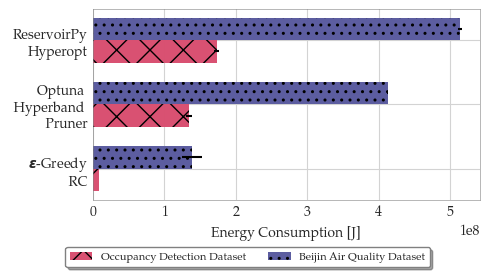

In [88]:
import matplotlib.pyplot as plt
import numpy as np

hatchs = [
    "..",
    "x",
    "o",
    "-",
    "+",
    "O",
    "x",
    ".",
]

# Example data
air_quality_joules = [_dict["airQuality"]["joule"]["reservoirpy"], _dict["airQuality"]["joule"]["optuna"], _dict["airQuality"]["joule"]["mab"]]   
occupancy_joules = [_dict["occupancy"]["joule"]["reservoirpy"], _dict["occupancy"]["joule"]["optuna"], _dict["occupancy"]["joule"]["mab"]]

air_quality_std = [_dict["airQuality"]["std"]["reservoirpy"], _dict["airQuality"]["std"]["optuna"], _dict["airQuality"]["std"]["mab"]]
occupancy_std = [_dict["occupancy"]["std"]["reservoirpy"], _dict["occupancy"]["std"]["optuna"], _dict["occupancy"]["std"]["mab"]]

categories = ['ReservoirPy\nHyperopt', 'Optuna \n Hyperband \n Pruner', r"$\epsilon$"+"-Greedy\n RC"]
y_pos = np.arange(len(categories))

# Plot
bar_width = 0.35
fig, ax = plt.subplots(figsize=(5, 3))

# Clustered bars
ax.barh(y_pos + bar_width / 2, occupancy_joules, bar_width, label="Occupancy Detection Dataset", color=colors[1], xerr=occupancy_std, hatch=hatchs[1], alpha=0.99)
ax.barh(y_pos - bar_width / 2, air_quality_joules, bar_width, label="Beijin Air Quality Dataset", color=colors[0], xerr=air_quality_std, hatch=hatchs[0], alpha=0.99)

# Labels and title
ax.set_xlabel('Energy Consumption [J]')
# ax.set_title('Power Consumption by Search Strategy and Dataset')
ax.set_yticks(y_pos)
ax.set_yticklabels(categories)
ax.invert_yaxis()
ax.legend(loc='center', bbox_to_anchor=(0.4, -0.3), fancybox=True, shadow=True, ncol=2, fontsize=8)

# Show plot
plt.tight_layout()
# plt.show()

plt.savefig("power_consumption.pdf", bbox_inches='tight')
